# Tutorial on Classifying Messages as Spam and Ham

This is a ML approach using tensorflow on the dataset which classifies email as Spam and Not spam.

In [1]:
## Importing modules
from __future__ import division
import tensorflow as tf
import numpy as np
import tarfile
import os
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [2]:
def csv_to_numpy_array(filePath, delimiter):
    return np.genfromtxt(filePath, delimiter=delimiter, dtype=None)

def import_data():
    if "data" not in os.listdir(os.getcwd()):
        # Untar directory of data if we haven't already
        tarObject = tarfile.open("Data/data.tar.gz")
        tarObject.extractall()
        tarObject.close()
        print("Extracted tar to current directory")
    else:
        # we've already extracted the files
        pass

    print("loading training data...")
    trainX = csv_to_numpy_array("data/trainX.csv", delimiter="\t")
    trainY = csv_to_numpy_array("data/trainY.csv", delimiter="\t")
    print("loading test data...")
    testX = csv_to_numpy_array("data/testX.csv", delimiter="\t")
    testY = csv_to_numpy_array("data/testY.csv", delimiter="\t")
    print("Done!")
    
    return trainX,trainY,testX,testY

trainX,trainY,testX,testY = import_data()

Extracted tar to current directory
loading training data...
loading test data...
Done!


In [3]:
#########################
### GLOBAL PARAMETERS ###
#########################

# DATA SET PARAMETERS
# Get our dimensions for our different variables and placeholders:
# numFeatures = the number of words extracted from each email
numFeatures = trainX.shape[1]
# numLabels = number of classes we are predicting (here just 2: Ham or Spam)
numLabels = trainY.shape[1]

# TRAINING SESSION PARAMETERS
# number of times we iterate through training data
# tensorboard shows that accuracy plateaus at ~25k epochs
numEpochs = 27000
# a smarter learning rate for gradientOptimizer
learningRate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [4]:
####################
### PLACEHOLDERS ###
####################

# X = X-matrix / feature-matrix / data-matrix... It's a tensor to hold our email
# data. 'None' here means that we can hold any number of emails
X = tf.placeholder(tf.float32, [None, numFeatures])
# yGold = Y-matrix / label-matrix / labels... This will be our correct answers
# matrix. Every row has either [1,0] for SPAM or [0,1] for HAM. 'None' here 
# means that we can hold any number of emails
yGold = tf.placeholder(tf.float32, [None, numLabels])

In [5]:
#################
### VARIABLES ###
#################

# Values are randomly sampled from a Gaussian with a standard deviation of:
#     sqrt(6 / (numInputNodes + numOutputNodes + 1))

weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=(np.sqrt(6/numFeatures+
                                                         numLabels+1)),
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias"))

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
######################
### PREDICTION OPS ###
######################

# INITIALIZE our weights and biases
init_OP = tf.initialize_all_variables()

# PREDICTION ALGORITHM i.e. FEEDFORWARD ALGORITHM
apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [7]:
#####################
### EVALUATION OP ###
#####################

# COST FUNCTION i.e. MEAN SQUARED ERROR
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")

In [8]:
#######################
### OPTIMIZATION OP ###
#######################

# OPTIMIZATION ALGORITHM i.e. GRADIENT DESCENT
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

<IPython.core.display.Javascript object>


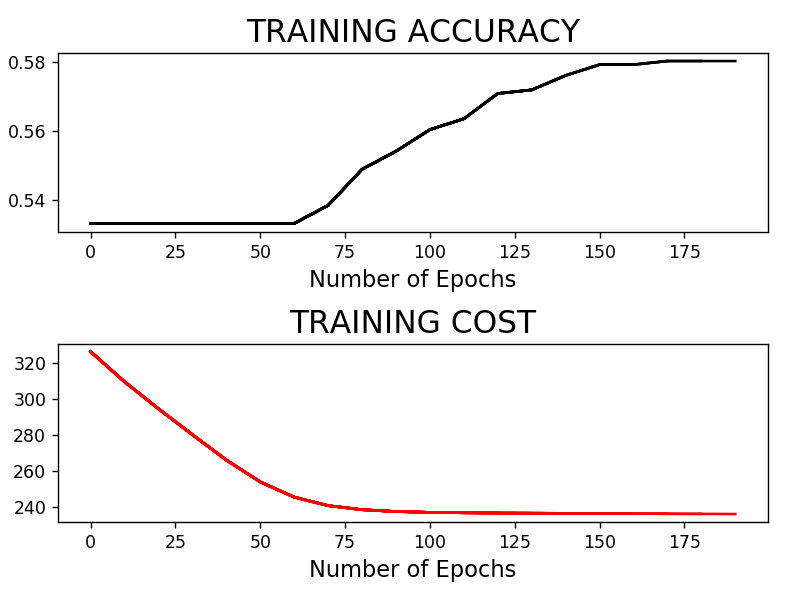

step 0, change in cost 326.325
step 10, change in cost 16.7622
step 20, change in cost 15.0468
step 30, change in cost 14.4467
step 40, change in cost 14.123
step 50, change in cost 12.1992
step 60, change in cost 8.46556
step 70, change in cost 4.72818
step 80, change in cost 2.27444
step 90, change in cost 1.02199
step 100, change in cost 0.463379
step 110, change in cost 0.230316
step 120, change in cost 0.136383
step 130, change in cost 0.098999
step 140, change in cost 0.0843658
step 150, change in cost 0.0785065
step 160, change in cost 0.0762939
step 170, change in cost 0.0753632
step 180, change in cost 0.0750275
step 190, change in cost 0.0748901
change in cost 0.0748901; convergence.
final accuracy on test set: 0.52380955


In [10]:
###########################
### GRAPH LIVE UPDATING ###
###########################
%matplotlib notebook

epoch_values=[]
accuracy_values=[]
cost_values=[]
# Turn on interactive plotting
plt.ion()
# Create the main, super plot
fig = plt.figure()
# Create two subplots on their own axes and give titles
ax1 = plt.subplot("211")
ax1.set_title("TRAINING ACCURACY", fontsize=18)
ax1.set_xlabel('Number of Epochs', fontsize=13)
ax2 = plt.subplot("212")
ax2.set_title("TRAINING COST", fontsize=18)
ax2.set_xlabel('Number of Epochs', fontsize=13)
plt.tight_layout()

#####################
### RUN THE GRAPH ###
#####################

# Create a tensorflow session
sess = tf.Session()

# Initialize all tensorflow variables
sess.run(init_OP)

## Ops for vizualization
# argmax(activation_OP, 1) gives the label our model thought was most likely
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))
# False is 0 and True is 1, what was our average?
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))
# Summary op for regression output
activation_summary_OP = tf.summary.histogram("output", activation_OP)
# Summary op for accuracy
accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)
# Summary op for cost
cost_summary_OP = tf.summary.scalar("cost", cost_OP)
# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))
# Merge all summaries
all_summary_OPS = tf.summary.merge_all()
# Summary writer
writer = tf.summary.FileWriter("summary_logs", sess.graph)

# Initialize reporting variables
cost = 0
diff = 1

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .075:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            summary_results, train_accuracy, newCost = sess.run(
                [all_summary_OPS, accuracy_OP, cost_OP], 
                feed_dict={X: trainX, yGold: trainY}
            )
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Write summary stats to writer
            writer.add_summary(summary_results, i)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            #print("step %d, training accuracy %g"%(i, train_accuracy))
            #print("step %d, cost %g"%(i, newCost))
            print("step %d, change in cost %g"%(i, diff))

            # Plot progress to our two subplots
            accuracyLine, = ax1.plot(epoch_values, accuracy_values, color = 'k')
            costLine, = ax2.plot(epoch_values, cost_values, color = 'r')
            fig.canvas.draw()
            time.sleep(1)


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: testX, 
                                                                yGold: testY})))